# Real-time Data from Axial Seamount
Written by Sage Lichtenwalner, Rutgers University, November 25, 2024

<p style="float: right;">
    <img src="https://oceanobservatories.org/wp-content/uploads/2024/07/Picture1.png" width="400px">
</p>

In 2015, the Axial Seamount volcano off the coasts of Washington and Oregon erupted.  But unlike previous eruptions, this time the network of sensors put in place by the **NSF Ocean Observatories Initiative (OOI)** was there to record the event in realtime.  As the most instrumented underwater volcano in the world, Axial Seamount is helping scientists better understand how underwater volcanoes work. 

And it's [about to erupt again](https://oceanobservatories.org/2024/07/axial-seamount-the-phoenix-rises/)!

### Accessing the latest data 

In this notebook, we will recreate the plot included in the story above, but with the latest data from the OOI's **Regional Cabled Array** so you can follow the potential eruption in realtime!

Specifically, we will demonstrate how to load and visualize data from:
* Bottom Pressure data from the Central Caldera, 
* Vent fluid data from a nearby hydrothermal vent in the *International District*,  
* And the catalog of earthquakes provided by W. Wilcock’s [Axial Earthquake Catalogue](http://axial.ocean.washington.edu) at UW.  


For more information about how underwater volcanos work, and the data collected by the NSF OOI during the 2015 eruption, we encourage you to check out [Lab 4 - Sea floor changes in a volcanically active setting](https://datalab.marine.rutgers.edu/ooi-lab-exercises/lab-4-sea-floor-changes-in-a-volcanically-active-setting/) in the OOI Lab Manual.

You should also check out the [latest Axial inflation forecast](https://axial.ceoas.oregonstate.edu) provided by W. Chadwick's team at OSU.  This site is updated daily with the latest estimate of when the eruption is likely to occur.

In [1]:
# Install erddapy if needed (required if running on Google Colab)
# !pip install erddapy

In [2]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt

## Dataset 1: Bottom Pressure Data
First let's load the [bottom pressure data](https://oceanobservatories.org/instrument-class/botpt/) collected in the Central Caldera at Axial Seamount.  The OOI team  refers to this instrument as BOTPT, because it measures bottom pressure and tilt.  This is the same dataset that is featured on Bill Chadwick's site above.

*Note, this dataset is very large, so it will take some time if you load the full time range.*

In [3]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

# Create the URL for this dataset
url = e.get_download_url(
    dataset_id = "ooi-rs03ccal-mj03f-05-botpta301",
    constraints = {
      # "time>=": "2024-05-01",
      # "time<=": "2024-12-01",
    },
    variables = ['time','botsflu_meanpres']
)
# print(url)

# Load the data into a pandas dataframe
botpt = pd.read_csv(url, index_col='time', parse_dates=True, skiprows=[1])
botpt.head()

,botsflu_meanpres
time,
2014-08-29 20:59:00+00:00,2255.105387
2014-08-29 21:00:00+00:00,2255.102559
2014-08-29 21:01:00+00:00,2255.102181
2014-08-29 21:02:00+00:00,2255.106222
2014-08-29 21:03:00+00:00,2255.116496


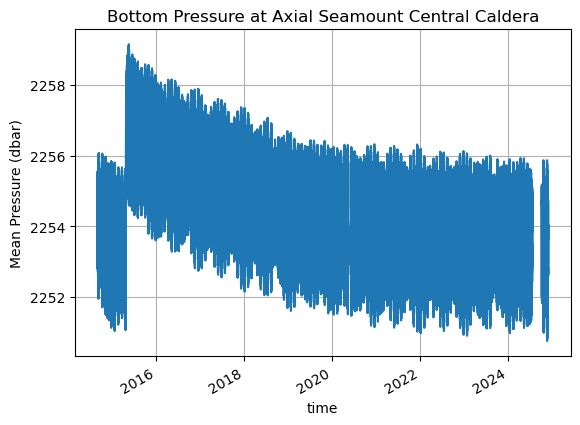

In [4]:
# Let's plot the pressure data
botpt['botsflu_meanpres'].plot()
plt.title('Bottom Pressure at Axial Seamount Central Caldera')
plt.ylabel('Mean Pressure (dbar)')
plt.grid(True);

As you can see, this is a high-resolution dataset, with values for every minute.  (In fact, this is a downsampled dataset.  The raw instrument records 15 times a second!)

This graph shows the pressure of the water column over the sensor, which is related to water depth.  On the left, you can clearly see the eruption that occurred in 2015.  The pressure jumped up from about 2253.5 to 2257, which actually means the ocean in this location got deeper because the caldera sank following the eruption.  A more intuitive way to show this graph would be to flip the y-axis, so it more clearly reflects the depth of the water (that is, the height of the caldera).

The signal also includes the raw tides and waves.  There are several ways we can simplify the data, including detiding or filtering the signal.  But for this example, we will simply calculate an hourly average, and then take a rolling 72 hour average.  This is crude, but it should remove most of the tides and other short-term signals so we can focus on the longer-term trends.

In [5]:
df_resampled = botpt['botsflu_meanpres'].resample('1h').mean().rolling('72h', center=True, min_periods=60).mean()

And now, let's plot this resampled dataset.  

As noted before, this time we'll flip the y-axis so we can intuitively see the height of the volcano grow over time.  

We will also add lines to denote the level at which the 2015 eruption occurred, and a +/- 20cm window around that. 

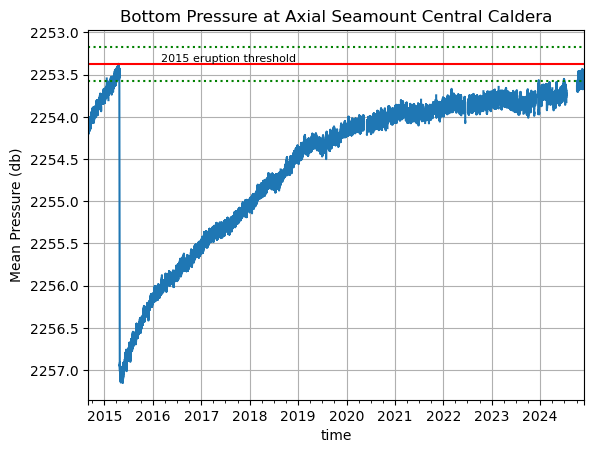

In [6]:
# Plot the resampled data
df_resampled.plot(label='Resampled Bottom Pressure')

plt.gca().invert_yaxis()
plt.title('Bottom Pressure at Axial Seamount Central Caldera')
plt.ylabel('Mean Pressure (db)')
plt.grid(True)

# Find the minimum value in 2015
min_2015 = df_resampled['2015'].min()

# Plot the horizontal lines
plt.axhline(min_2015, color='r', linestyle='-', label='2015 eruption threshold')
plt.axhline(min_2015 + 0.2, color='g', linestyle=':', label='+20cm')
plt.axhline(min_2015 - 0.2, color='g', linestyle=':', label='- 20cm')

# Label the lines on the graph
plt.text(pd.Timestamp('2016-03-01'), min_2015, '2015 eruption threshold', color='k', va='bottom', fontsize=8);
# plt.text(pd.Timestamp('2016-03-01'), min_2015 + 0.2, '+20cm', color='k', va='center', fontsize=8)
# plt.text(pd.Timestamp('2016-03-01'), min_2015 - 0.2, '-20cm', color='k', va='center', fontsize=8)

### Questions
1. What trends do you observe in the bottom pressure data over the past decade?
2. How close are the current pressure measurements to the 2015 eruption?
3. How has the inflation rate (that is the rate of change in pressure), changed over time?
4. Based in this information, do you the an eruption is imminent? 

### Inflation Rate
To further investigate any trends there may be in this dataset, let's calculate the long-term change.

Bill Chadwick's site estimates the date of a possible future eruption using several different models.  A common approach is to look at the recent inflation rate and then estimate the date when the seafloor will reach the same height it erupted at last time, plus or minus some variation.  One can calculate a range of estimates using the 1, 3 or 6 month rates of inflation, which is helpful because the rates themselves often change over time.

We won't calculate an estimate here, but let's look at the inflation rate for these three time periods to see how the rate has varied over time.

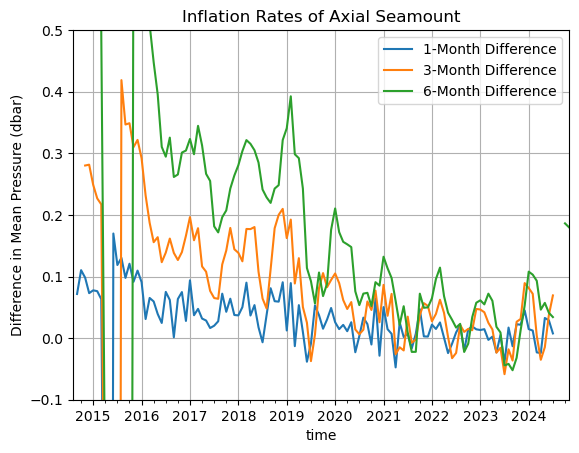

In [7]:
# Calculate the 3-month difference for each month
df_resampled_monthly = df_resampled.resample('1MS').mean()
df_1month_diff = df_resampled_monthly.shift(1) - df_resampled_monthly
df_3month_diff = df_resampled_monthly.shift(3) - df_resampled_monthly
df_6month_diff = df_resampled_monthly.shift(6) - df_resampled_monthly

# Plot the 6-month difference
df_1month_diff.plot(label='1-Month Difference')
df_3month_diff.plot(label='3-Month Difference')
df_6month_diff.plot(label='6-Month Difference')
plt.title('Inflation Rates of Axial Seamount')
plt.ylabel('Difference in Mean Pressure (dbar)')
plt.grid(True)
plt.ylim(-.1, 0.5)
plt.legend();

### Questions
1. How does the inflation rate change over different time periods (1-month, 3-month, 6-month)?
2. Has the inflation rate been constant over time?
3. What do you think a negative inflation rate means?
4. How does the most recent inflation rate compare with earlier rates?
5. Based in this information, do you the an eruption is imminent? 

## Dataset 2: Earthquake Data

Next let's load the William Wilcock's [Axial Seamount earthquake dataset](http://axial.ocean.washington.edu/).  

This file is in a unique format so we will use a custom parser to load it.  We will also need to convert some of the columns.

This catalog includes all of the individual earthquakes that were detected around the seamount.  To simplify this dataset, let's calculate the number of earthquakes per day.  That way, we can compare the earthquake activity around the 2015 eruption to the present day, and see how close we might be to the next eruption event.

In [8]:
# Load in the earthquake data
df_eq = pd.read_csv('http://axial.ocean.washington.edu/hypo71.dat', sep='\s+', skiprows=1, engine='python',
  names=['yyyymmdd', 'HHMM', 'SSS.SS','Lat_D','Lat_M','Lon_D','Lon_M','Depth','MW','NWR','GAP','DMIN','RMS','ERH','ERZ','ID','PMom','SMom'])
df_eq.head()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mz/ql7rs9ks275g1s0ptc3k3vhh0000gn/T/ipykernel_43894/435851194.py:2: SyntaxWarning: invalid escape sequence '\s'
  df_eq = pd.read_csv('http://axial.ocean.washington.edu/hypo71.dat', sep='\s+', skiprows=1, engine='python',


,yyyymmdd,HHMM,SSS.SS,Lat_D,Lat_M,Lon_D,Lon_M,Depth,MW,NWR,GAP,DMIN,RMS,ERH,ERZ,ID,PMom,SMom
0,20150122,0,27.54,45,56.81,129,59.92,0.55,-0.31,7,206,1.2,0.03,0.8,0.4,20830,3.800000e+17,3.900000e+17
1,20150122,8,58.89,45,56.96,129,59.70,0.00,0.02,10,149,1.2,0.09,0.2,0.2,20831,1.900000e+18,7.800000e+17
2,20150122,202,41.04,45,56.47,130,0.89,0.67,-0.03,12,200,0.8,0.03,0.9,0.7,20836,1.400000e+18,7.200000e+17
3,20150122,219,56.90,45,54.93,129,57.59,1.60,0.26,7,325,1.8,0.06,1.4,2.5,20837,3.300000e+18,2.200000e+18
4,20150122,236,7.08,45,56.80,129,59.71,0.51,-0.15,8,160,1.2,0.06,0.5,0.2,20840,6.700000e+17,6.800000e+17


In [9]:
# Convert lat/long from degrees and minutes to decimal degrees
def dms_to_dd(degrees, minutes):
    dd = float(degrees) + float(minutes) / 60
    return dd

df_eq['Lat_DD'] = df_eq.apply(lambda row: dms_to_dd(row['Lat_D'], row['Lat_M']), axis=1)
df_eq['Lon_DD'] = df_eq.apply(lambda row: dms_to_dd(row['Lon_D'], row['Lon_M']), axis=1)

# Convert Year, Month, Day, Hour, Minute, Second to a datetime object
df_eq['Datetime'] = pd.to_datetime(df_eq['yyyymmdd'].astype(str) + df_eq['HHMM'].astype(str).str.zfill(4), format='%Y%m%d%H%M')

# Set Datetime as the index
df_eq.set_index('Datetime', inplace=True)

In [10]:
# Group by day and count the number of earthquakes
daily_earthquake_counts = df_eq['MW'].resample('D').count()
daily_earthquake_counts.head()

Datetime
2015-01-22     67
2015-01-23     71
2015-01-24    151
2015-01-25    100
2015-01-26    350
Freq: D, Name: MW, dtype: int64

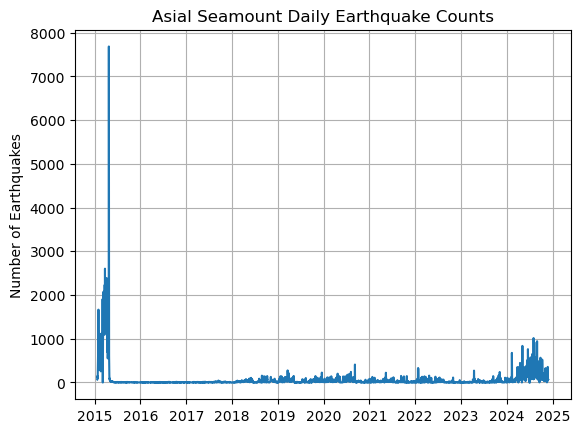

In [11]:
# Plot the daily earthquake counts
plt.plot(daily_earthquake_counts.index, daily_earthquake_counts.values)
plt.title('Asial Seamount Daily Earthquake Counts')
plt.ylabel('Number of Earthquakes')
plt.grid(True);

### Questions
1. How has the number of earthquakes per day changed over time?
2. About how many earthquakes per day were there on average leading up to the eruption?  
3. What about the day of the eruption?
4. About how many earthquakes per day are occurring now?  How does that compare with values seen before the 2015 eruption?
5. Based in this information, do you the an eruption is imminent? 

## Pulling it all together
Let's create a combined plot to show all 3 datasets together.

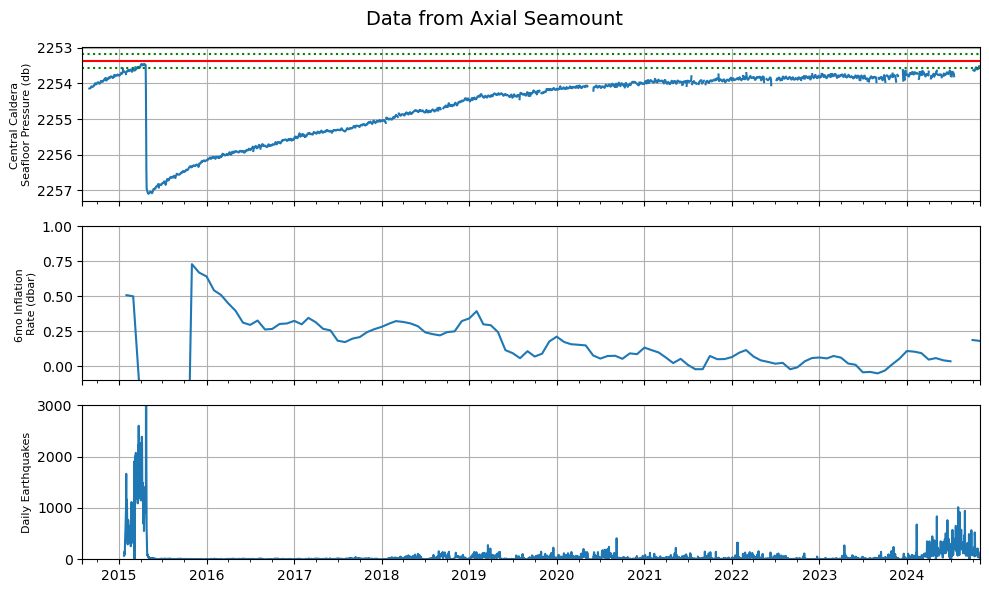

In [12]:
# Plot all the data together
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# BOTPT Pressure
df_resampled.resample('1D').mean().plot(ax=ax1, label='Resampled Bottom Pressure')
ax1.invert_yaxis()
ax1.set_ylabel('Central Caldera \nSeafloor Pressure (db)', fontsize=8)
ax1.grid(True)
# Plot the threshold line
ax1.axhline(min_2015, color='r', linestyle='-', label='2015 eruption threshold')
ax1.axhline(min_2015 + 0.2, color='g', linestyle=':', label='+20cm')
ax1.axhline(min_2015 - 0.2, color='g', linestyle=':', label='- 20cm')

# Long-term inflation rate
df_6month_diff.plot(ax=ax2)
ax2.set_ylabel('6mo Inflation \nRate (dbar)', fontsize=8)
ax2.set_ylim(-.1, 1.0)
ax2.grid(True)

# Daily Earthquakes
ax3.plot(daily_earthquake_counts.index, daily_earthquake_counts.values)
ax3.set_ylabel('Daily Earthquakes', fontsize=8)
ax3.set_ylim(0, 3000)
ax3.grid(True)

fig.suptitle('Data from Axial Seamount', fontsize=14);
fig.tight_layout();

### Questions
1. What trends do you observe in the bottom pressure data over the past decade?
2. How does the inflation rate change over different time periods?
3. What patterns do you notice in the daily earthquake counts? Are there any significant spikes?


## Dataset 3: Vent Fluid Temperature
Let's take a look at a new instrument that was installed in April of 2024.  

The [hydrothermal vent fluid temperatures](https://oceanobservatories.org/instrument-class/trhph/) was placed inside a vent in the *International District*, which is located inside the caldera.  

While this sensor doesn't have a long history, as the eruption gets closer we can observe how the temperature increases or fluctuates.  So this dataset may prove interesting as the next eruption approaches.

In [13]:
# Load the thermistor dataset 
url = e.get_download_url(
    dataset_id = "ooi-rs03int1-mj03c-09-trhpha302",
    variables = ['time','trhphte_abs']
)
trhph = pd.read_csv(url, index_col='time', parse_dates=True, skiprows=[1])

# Calculate the daily mean
trhph_daily_mean = trhph['trhphte_abs'].resample('D').mean()

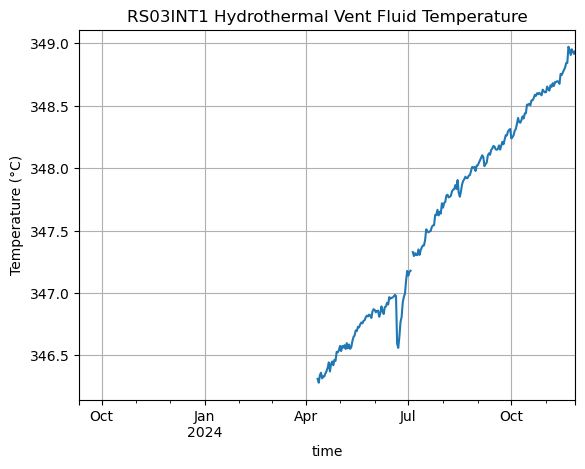

In [14]:
trhph_daily_mean.plot()
plt.title('RS03INT1 Hydrothermal Vent Fluid Temperature')
plt.ylabel('Temperature (°C)')
plt.grid(True);

## Conclusion: Focusing on the last year
Finally, let's take a look at the last year, which allows us to zoom into the recent measurements.

Based on the recent trends in all of the dataset, can you make a prediction on how soon the next eruption will occur?

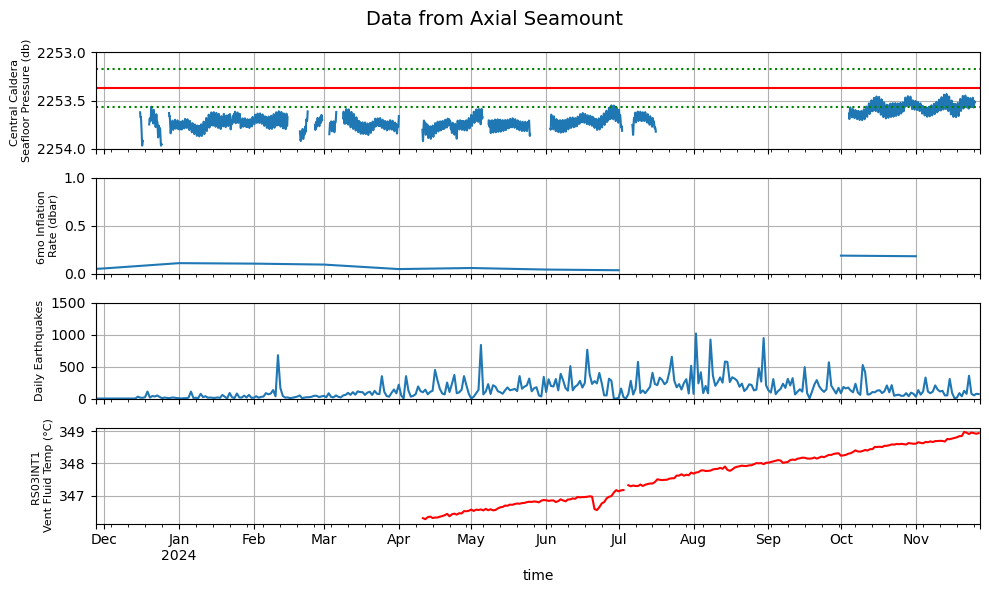

In [15]:
# Plot all the data including vent fluid for the last year
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

# BOTPT Pressure
df_resampled.plot(ax=ax1, label='Resampled Bottom Pressure')
ax1.invert_yaxis()
ax1.set_ylabel('Central Caldera \nSeafloor Pressure (db)', fontsize=8)
ax1.set_ylim(2254, 2253)
ax1.grid(True)
# Plot the threshold line
ax1.axhline(min_2015, color='r', linestyle='-', label='2015 eruption threshold')
ax1.axhline(min_2015 + 0.2, color='g', linestyle=':', label='+20cm')
ax1.axhline(min_2015 - 0.2, color='g', linestyle=':', label='- 20cm')

# Long-term inflation rate
df_6month_diff.plot(ax=ax2)
ax2.set_ylabel('6mo Inflation \nRate (dbar)', fontsize=8)
ax2.set_ylim(0, 1.0)
ax2.grid(True)

# Daily Earthquakes
daily_earthquake_counts.plot(ax=ax3)
ax3.set_ylabel('Daily Earthquakes', fontsize=8)
ax3.set_ylim(0, 1500)
ax3.grid(True)

# Plot the fluid temperature
trhph_daily_mean.plot(ax=ax4, color='r', label='Vent Fluid Temperature')
ax4.set_ylabel('RS03INT1 \nVent Fluid Temp (°C)', fontsize=8)
ax4.grid(True)

# Set the x-limit to the last year
ax4.set_xlim(pd.Timestamp.now() - pd.DateOffset(years=1), pd.Timestamp.now())

fig.suptitle('Data from Axial Seamount', fontsize=14);
fig.tight_layout();

### Questions
1. How close is the bottom pressure data to the 2015 eruption threshold?
2. Has the inflation rate changed over the past year?  Is it speeding up or slowing down?
3. How as the earthquake activity changed over the past year?  Is the number of quakes per day increasing or decreasing?
4. How does the vent fluid temperature correlate (or not) with the other datasets?
5. Based on the most recent data, can you predict when the next eruption might occur? What evidence supports your prediction?